# Introduction

This notebook will illustrate experiments with the Adam optimizer in TensorFlow to solve the `lagaris_02` ODE IVP.

## The `lagaris02` ODE problem

This ODE was used as the second example problem in (Lagaris et al., 1998). It has been used in several other papers in the neural network/differential equation literature. The differential equation is provided in the form (equation (28) in Lagaris (1998)):

\begin{equation}
    \frac {d\psi} {dx} + \frac {1} {5} \psi = e^{-x/5} \cos(x)
\end{equation}

or:

\begin{equation}
    G\left(x,\psi,\frac {d\psi}{dx}\right) = \frac {d\psi} {dx} + \frac {1} {5} \psi - e^{-x/5} \cos(x) = 0
\end{equation}

\begin{equation}
    \psi(0)=0
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x) = e^{-x/5} \sin (x)
\end{equation}

The first derivative is:

\begin{equation}
    \frac {d \psi_a} {dx} = e^{-x/5} \left( \cos(x) - \frac {1} {5} \sin(x) \right)
\end{equation}

The analytical solution and derivative in the domain $[0,1]$ are plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
from math import exp
import os
import platform
import sys

# Import 3rd-party modules.
import matplotlib.pyplot as plt
import numpy as np

# Import TensorFlow.
import tensorflow as tf

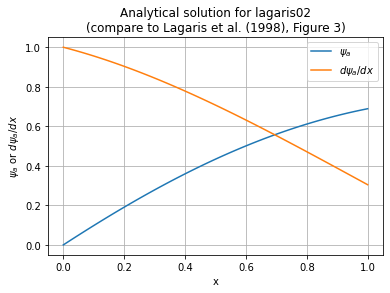

In [2]:
# Import the problem definition.
eq_name = "lagaris02"
eq_module = 'nnde.differentialequation.examples.lagaris_02'
eq = importlib.import_module(eq_module)

# Compute the analytical solution and derivative.
# Note that Y is used in place of \psi in the code.
na = 101
xa = np.linspace(0, 1, na)
Ya = [eq.Ya(x) for x in xa]
Ya = np.array(Ya)
dYa_dx = [eq.dYa_dx(x) for x in xa]
dYa_dx = np.array(dYa_dx)

# Plot the analytical solution and derivative.
plt.plot(xa, Ya, label="$\psi_a$")
plt.plot(xa, dYa_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s\n(compare to Lagaris et al. (1998), Figure 3)" %
         (eq_name));

## Solving `lagaris02` using TensorFlow

In [3]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [4]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [5]:
from nnde.math.trainingdata import create_training_grid

def create_training_data(nt):
    x_train = np.array(create_training_grid(nt))
    return x_train

In [6]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [7]:
print_system_information()

System report:
2021-09-16 17:26:47.870378
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Mon Aug 30 06:12:21 PDT 2021; root:xnu-7195.141.6~3/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
Python build: ('default', 'Aug  6 2021 08:56:27')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [8]:
# Buid and train the model.

# Set up the output directory.
path = "./lagaris_02_tf_adam"
output_dir = create_output_directory(path)

# Training optimizer
training_algorithm = "Adam"

# Initial parameter ranges
w0_range = [-1, 1]
u0_range = [-1, 1]
v0_range = [-1, 1]

# Number of hidden nodes.
H = 10

# Number of training points.
nt = 10

# Number of validation points.
nv = 101

# Number of training epochs.
n_epochs = 1000

# Learning rate.
learning_rate = 0.01

# Random number generator seed.
random_seed = 0

# Create and save the training data, then convert to Variable.
xt = create_training_data(nt)
np.savetxt(os.path.join(output_dir,'xt.dat'), xt)
xtv = tf.Variable(xt.reshape((nt, 1)), dtype=tf.float32)

# Build the model.
model = build_model(H, w0_range, u0_range, v0_range)

# Create history variables.
losses = []
phist = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Create the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Train the model.

# Rename the training data Variable for convenience, just for training.
x = xtv

print("Hyperparameters: nt = %s, H = %s, n_epochs = %s, learning_rate = %s"
      % (nt, H, n_epochs, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(n_epochs):
#     print("Starting epoch %s." % epoch)

    # Run the forward pass.
    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape1:

            # Compute the network output.
            N = model(x)

            # Compute the trial solution.
            Y = x*N

        # Compute the gradient of trial solution wrt inputs.
        dY_dx = tape1.gradient(Y, x)

        # Compute the estimate of the differential equation.
        # This line takes as much time as everything above combined.
        G = dY_dx + 1/5*Y - tf.math.exp(-x/5)*tf.math.cos(x)

        # Compute the loss function. x has nt elements (training points).
        L = tf.math.sqrt(tf.reduce_sum(G**2)/nt)

    # Save the current loss.
    losses.append(L.numpy())

    # Compute the gradient of the loss function wrt the network parameters.
    # This line takes as much time as everything above combined.
    pgrad = tape2.gradient(L, model.trainable_variables)

    # Save the parameters used in this pass.
    # This line adds about 1 second.
    phist.append(
        np.hstack(
            (model.trainable_variables[0][0].numpy(),    # w (1, H) matrix
             model.trainable_variables[1].numpy(),       # u (H,) row vector
             model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this pass.
    # This line adds about 1.5 seconds.
    optimizer.apply_gradients(zip(pgrad, model.trainable_variables))

#     print("Ending epoch %s." % epoch)

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())

# Save the parameter history.
np.savetxt(os.path.join(output_dir, 'phist.dat'), np.array(phist))

# Compute and save the trained results at training points (Ytt).
with tf.GradientTape() as tape:
    N = model(xtv)
    Ytt = xtv*N
np.savetxt(os.path.join(output_dir, 'Ytt.dat'), Ytt.numpy().reshape((nt)))
dYtt_dx = tape.gradient(Ytt, xtv)
np.savetxt(os.path.join(output_dir, 'dYtt_dx.dat'), dYtt_dx.numpy().reshape((nt)))

# Compute and save the analytical solution and derivative at training points (Yat).
Yat = np.array([eq.Ya(x) for x in xt])
np.savetxt(os.path.join(output_dir,'Yat.dat'), Yat)
dYat_dx = np.array([eq.dYa_dx(x) for x in xt])
np.savetxt(os.path.join(output_dir,'dYat_dx.dat'), dYa_dx)

# Compute and save the error in the trained solution and derivative at training points (Ytt_err).
Ytt_err = Ytt.numpy().reshape((nt)) - Yat
np.savetxt(os.path.join(output_dir, 'Ytt_err.dat'), Ytt_err)
dYtt_dx_err = dYtt_dx.numpy().reshape((nt)) - dYat_dx
np.savetxt(os.path.join(output_dir, 'dYtt_dx_err.dat'), dYtt_dx_err)

# Compute the validation points (xv).
# xv = create_training_data(nv)*3 - 1
xv = create_training_data(nv)
np.savetxt(os.path.join(output_dir,'xv.dat'), xv)
xvv = tf.Variable(xv.reshape((nv, 1)), dtype=tf.float32)

# Compute and save the trained results at the validation points (Ytv).
with tf.GradientTape() as tape:
    N = model(xvv)
    Ytv = xvv*N
np.savetxt(os.path.join(output_dir, 'Ytv.dat'), Ytv.numpy().reshape((nv)))
dYtv_dx = tape.gradient(Ytv, xvv)
np.savetxt(os.path.join(output_dir, 'dYtv_dx.dat'), dYtv_dx.numpy().reshape((nv)))

# Compute and save the analytical solution and derivative at validation points (Yav).
Yav = np.array([eq.Ya(x) for x in xv])
np.savetxt(os.path.join(output_dir,'Yav.dat'), Yav)
dYav_dx = np.array([eq.dYa_dx(x) for x in xv])
np.savetxt(os.path.join(output_dir,'dYav_dx.dat'), dYav_dx)

# Compute and save the error in the trained solution and derivative at validation points (Ytv_err).
Ytv_err = Ytv.numpy().reshape((nv)) - Yav
np.savetxt(os.path.join(output_dir, 'Ytv_err.dat'), Ytv_err)
dYtv_dx_err = dYtv_dx.numpy().reshape((nv)) - dYav_dx
np.savetxt(os.path.join(output_dir, 'dYtv_dx_err.dat'), dYtv_dx_err)

Hyperparameters: nt = 10, H = 10, n_epochs = 1000, learning_rate = 0.01
Training started at 2021-09-16 17:26:47.926417


2021-09-16 17:26:47.914000: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training stopped at 2021-09-16 17:26:52.445317
Total training time was 4.5189 seconds.


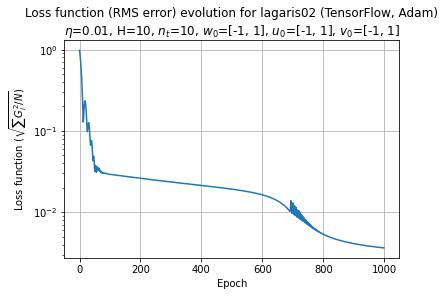

In [9]:
# Plot the loss function history.
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.title("Loss function (RMS error) evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.show()

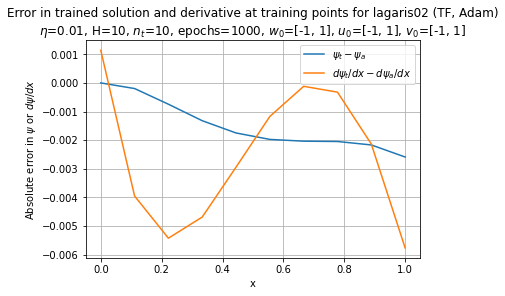

In [10]:
# Plot the errors in the trained solution and derivative at the training points.
plt.plot(xt, Ytt_err, label="$\psi_t - \psi_a$")
plt.plot(xt, dYtt_dx_err, label="$d\psi_t/dx - d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi$ or $d\psi/dx$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivative at training points for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, epochs=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TF', training_algorithm, learning_rate, H, nt, n_epochs, w0_range, u0_range, v0_range))
plt.show()

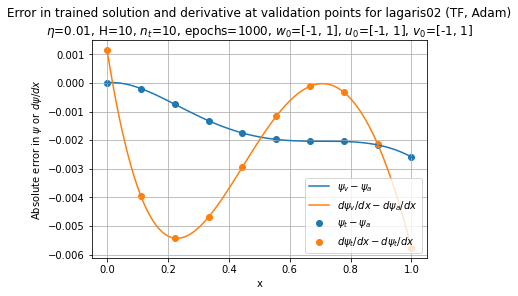

In [11]:
# Plot the errors in the trained solution and derivative at the validation points.
plt.plot(xv, Ytv_err, label="$\psi_v - \psi_a$")
plt.scatter(xt, Ytt_err, label="$\psi_t - \psi_a$", marker='o')
plt.plot(xv, dYtv_dx_err, label="$d\psi_v/dx - d\psi_a/dx$")
plt.scatter(xt, dYtt_dx_err, label="$d\psi_t/dx - d\psi_t/dx$", marker='o')
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi$ or $d\psi/dx$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivative at validation points for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, epochs=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TF', training_algorithm, learning_rate, H, nt, n_epochs, w0_range, u0_range, v0_range))
plt.show()

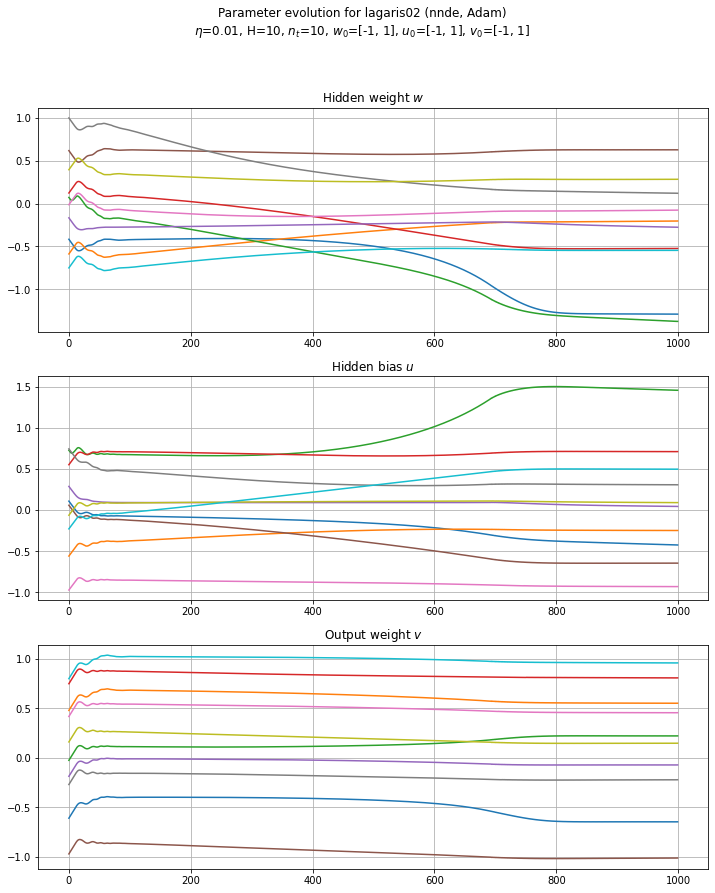

In [12]:
# Plot the parameter histories.
phist = np.array(phist)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TF', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.subplots_adjust(hspace=0.2)
plt.show()